## Call the import statements

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows=10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
tf.keras.backend.set_floatx('float32') # set defaults float type

## Load, scale, and shuffle the examples

In [4]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [5]:
train_df.iloc[3664]

longitude              -117.9
latitude                 33.8
housing_median_age       34.0
total_rooms             988.0
total_bedrooms          173.0
population              759.0
households              184.0
median_income             5.6
median_house_value   205100.0
Name: 3664, dtype: float64

In [6]:
scale_factor = 1000
train_df['median_house_value'] = train_df['median_house_value'] / scale_factor
test_df['median_house_value'] /= scale_factor

In [7]:
train_df = train_df.sample(frac=1) # or
train_df = train_df.reindex(np.random.permutation(train_df.index))

## Represent latitude and longitude as floating-point values

In [8]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

In [9]:
# Create a numerical feature column to represent latitude.
latitude = tf.feature_column.numeric_column('latitude')
feature_columns.append(latitude)

In [10]:
# Create a numerical feature column to represent longitude.
longitude = tf.feature_column.numeric_column('longitude')
feature_columns.append(longitude)

In [11]:
len(feature_columns)

2

In [12]:
# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

## what happened inside feature_layer?

In [13]:
tdf1 = train_df.to_dict() #ordereddict

In [14]:
tdf1['latitude'] = tdf1['latitude'].values() # convert to list by removing index

In [15]:
tdf1['longitude'] = tdf1['longitude'].values()

In [16]:
fp_feature_layer(tdf1)

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[  34.17, -118.12],
       [  37.64, -122.11],
       [  34.08, -118.36],
       ...,
       [  37.67, -122.14],
       [  39.52, -121.61],
       [  37.84, -120.2 ]], dtype=float32)>

## Define functions that create and train a model, and a plotting function

In [17]:
def create_model(my_learning_rate, feature_layer):
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    model.add(feature_layer)
    # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                 loss='mean_squared_error',
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [18]:
def train_model(model, dataset, epochs, batch_size, label_name):
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                       epochs=epochs, shuffle=True)
    
    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch
    
    # Isolate the mean absolute error for each epoch.
    hist = pd.DataFrame(history.history)
    rmse = hist['root_mean_squared_error']
    
    return epochs, rmse

In [19]:
def plot_the_loss_curve(epochs, rmse):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error')
    
    plt.plot(epochs, rmse, label='Loss')
    plt.legend()
    plt.ylim([rmse.min()*0.94, rmse.max()*1.05])
    plt.show()
    
print('Defined the create_model, train_model, and plot_the_loss-curve functions')

Defined the create_model, train_model, and plot_the_loss-curve functions


## Train the model with floating-point representations

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 462us/step - loss: 17722.2891 - root_mean_squared_error: 133.1251
Epoch 2/30
170/170 [==============================] - 0s 444us/step - loss: 13498.8584 - root_mean_squared_error: 116.1846
Epoch 3/30
170/170 [==============================] - 0s 472us/step - loss: 13434.3682 - root_mean_squared_error: 115.9067
Epoch 4/30
170/170 [==============================] - 0s 536us/step - loss: 13403.3701 - root_mean_squared_error: 115.7729
Epoch 5/30
170/170 [==============================] - 0s 451us/step - loss: 13364.6738 - root_mean_squared_error: 115.6057
Epoch 6/30
170/170 [==============================] - 0s 447us/step - loss: 13313.1035 - root_mean_squared_error: 115.3824
Epoch 7/30
170/170 [==============================] - 0s 444us/step - loss: 13263.9580 - root_mean_squared_error: 115.1693
Epoch 8/30
170/170 [=========

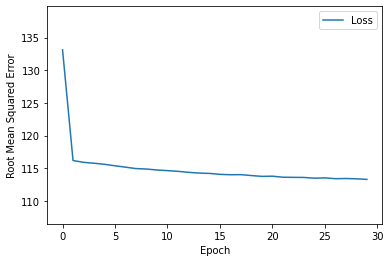


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 447us/step - loss: 12171.6064 - root_mean_squared_error: 110.3250


[12171.6064453125, 110.32500457763672]

In [20]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print('\n: Evaluate the new model against the test set:')
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## tf.feature_column.numeric_column

In [21]:
data = {'a': [15, 9, 17, 19, 21, 18, 25, 30],
   'b': [5.0, 6.4, 10.5, 13.6, 15.7, 19.9, 20.3 , 0.0]}

In [22]:
a = tf.feature_column.numeric_column('a')
b = tf.feature_column.numeric_column('b')

In [23]:
a_buckets = tf.feature_column.bucketized_column(a,
   boundaries=[10, 15, 20, 25, 30])

In [24]:
feature_layer = tf.keras.layers.DenseFeatures([a, b])
print(feature_layer(data))

tf.Tensor(
[[15.   5. ]
 [ 9.   6.4]
 [17.  10.5]
 [19.  13.6]
 [21.  15.7]
 [18.  19.9]
 [25.  20.3]
 [30.   0. ]], shape=(8, 2), dtype=float32)


In [25]:
feature_layer = tf.keras.layers.DenseFeatures([a_buckets, b])
print(feature_layer(data))

tf.Tensor(
[[ 0.   0.   1.   0.   0.   0.   5. ]
 [ 1.   0.   0.   0.   0.   0.   6.4]
 [ 0.   0.   1.   0.   0.   0.  10.5]
 [ 0.   0.   1.   0.   0.   0.  13.6]
 [ 0.   0.   0.   1.   0.   0.  15.7]
 [ 0.   0.   1.   0.   0.   0.  19.9]
 [ 0.   0.   0.   0.   1.   0.  20.3]
 [ 0.   0.   0.   0.   0.   1.   0. ]], shape=(8, 7), dtype=float32)


In [26]:
feature_layer = tf.keras.layers.DenseFeatures([a_buckets])
print(feature_layer(data))

tf.Tensor(
[[0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]], shape=(8, 6), dtype=float32)


## Task 1: Why aren't floating-point values a good way to represent latitude and longitude?

@title Double-click to view an answer to Task 1.

No. Representing latitude and longitude as floating-point values does not have much predictive power. For example, neighborhoods at latitude 35 are not 36/35 more valuable (or 35/36 less valuable) than houses at latitude 36.

Representing `latitude` and `longitude` as floating-point values provides almost no 
predictive power. We're only using the raw values to establish a baseline for future experiments 
with better representations.

## Represent latitude and longitude in buckets

In [27]:
resolution_in_degrees = 1.0

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude
# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])), 
                                     resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
                                               latitude_boundaries)
feature_columns.append(latitude)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])), 
                                      resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.

buckets_feature_layer = layers.DenseFeatures(feature_columns)

## Train the model with bucket representations

Epoch 1/35
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 482us/step - loss: 52006.4375 - root_mean_squared_error: 228.0492
Epoch 2/35
170/170 [==============================] - 0s 456us/step - loss: 44628.6562 - root_mean_squared_error: 211.2550
Epoch 3/35
170/170 [==============================] - 0s 456us/step - loss: 38045.8984 - root_mean_squared_error: 195.0536
Epoch 4/35
170/170 [==============================] - 0s 452us/step - loss: 32228.6191 - root_mean_squared_error: 179.5233
Epoch 5/35
170/170 [==============================] - 0s 461us/step - loss: 27222.6250 - root_mean_squared_error: 164.9928
Epoch 6/35
170/170 [==============================] - 0s 475us/step - loss: 22971.8027 - root_mean_squared_error: 151.5645
Epoch 7/35
170/170 [==============================] - 0s 486us/step - loss: 19468.0293 - root_mean_squared_error: 139.5279
Epoch 8/35
170/170 [=========

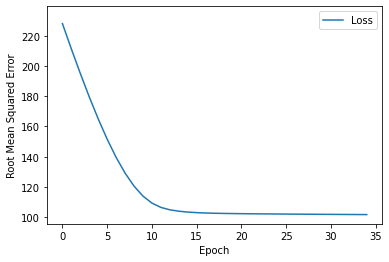


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 501us/step - loss: 10198.6582 - root_mean_squared_error: 100.9884


[10198.658203125, 100.9884033203125]

In [28]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35
batch_size = 100
label_name = 'median_house_value'

# Build the model, this time passing in the buckets_feature_layer.
my_model = create_model(learning_rate, buckets_feature_layer)

#Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print('\n: Evaluate the new model against the test set:')
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 2: Did buckets outperform floating-point representations?

### @title Double-click for an answer to Task 2.

Bucket representation outperformed floating-point representations.  
However, you can still do far better.

## Task 3: What is a better way to represent location?

Buckets are a big improvement over floating-point values. Can you identify an even better way to identify location with latitude and longitude?

In [36]:
resolution_in_degrees = 1.0

# Create a new empty list that will eventually hold the generated feature column
feature_columns = []

# Create a bucket feature column for latitude
latitude_as_a_numeric_column = tf.feature_column.numeric_column('latitude')
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude
longitude_as_a_numeric_column = tf.feature_column.numeric_column('longitude')
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries )

# Create a feature cross of latitude and longitude
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

# Convert the list of feature columns into a layer that will later be fed into the model.
feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

Epoch 1/35
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 541us/step - loss: 53537.2539 - root_mean_squared_error: 231.3812
Epoch 2/35
170/170 [==============================] - 0s 504us/step - loss: 48506.9531 - root_mean_squared_error: 220.2429
Epoch 3/35
170/170 [==============================] - 0s 492us/step - loss: 43819.1211 - root_mean_squared_error: 209.3302
Epoch 4/35
170/170 [==============================] - 0s 473us/step - loss: 39466.5078 - root_mean_squared_error: 198.6618
Epoch 5/35
170/170 [==============================] - 0s 497us/step - loss: 35459.1367 - root_mean_squared_error: 188.3060
Epoch 6/35
170/170 [==============================] - 0s 498us/step - loss: 31765.3906 - root_mean_squared_error: 178.2285
Epoch 7/35
170/170 [==============================] - 0s 501us/step - loss: 28418.2695 - root_mean_squared_error: 168.5772
Epoch 8/35
170/170 [=========

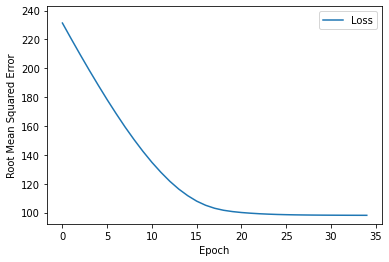


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 589us/step - loss: 9520.3975 - root_mean_squared_error: 97.5725


[9520.3974609375, 97.57252502441406]

In [37]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 4: Did the feature cross outperform buckets?

@title Double-click for an answer to this question.

Yes, representing these features as a feature cross produced much lower loss values than representing these features as buckets

## Task 5: Adjust the resolution of the feature cross

In [42]:
resolution_in_degrees = 0.4  # change 1.0 to 0.5

# Create a new empty list that will eventually hold the generated feature column
feature_columns = []

# Create a bucket feature column for latitude
latitude_as_a_numeric_column = tf.feature_column.numeric_column('latitude')
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), int(max(train_df['latitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude
longitude_as_a_numeric_column = tf.feature_column.numeric_column('longitude')
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), int(max(train_df['longitude'])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, longitude_boundaries )

# Create a feature cross of latitude and longitude
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

# Convert the list of feature columns into a layer that will later be fed into the model.
feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

Epoch 1/35
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 0s 498us/step - loss: 53663.2539 - root_mean_squared_error: 231.6533
Epoch 2/35
170/170 [==============================] - 0s 506us/step - loss: 48821.6758 - root_mean_squared_error: 220.9563
Epoch 3/35
170/170 [==============================] - 0s 496us/step - loss: 44307.8945 - root_mean_squared_error: 210.4944
Epoch 4/35
170/170 [==============================] - 0s 500us/step - loss: 40096.0859 - root_mean_squared_error: 200.2401
Epoch 5/35
170/170 [==============================] - 0s 498us/step - loss: 36180.3711 - root_mean_squared_error: 190.2114
Epoch 6/35
170/170 [==============================] - 0s 514us/step - loss: 32576.5449 - root_mean_squared_error: 180.4897
Epoch 7/35
170/170 [==============================] - 0s 496us/step - loss: 29279.7578 - root_mean_squared_error: 171.1133
Epoch 8/35
170/170 [=========

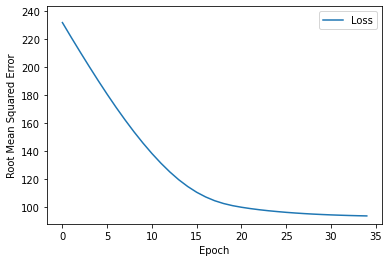


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 624us/step - loss: 8646.4678 - root_mean_squared_error: 92.9864


[8646.4677734375, 92.98638153076172]

In [43]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

@title Double-click for possible answers to Task 5.

1. A resolution of ~0.4 degree provides the best results.

2. Below ~0.4 degree, loss increases because the dataset does not contain enough examples in each cell to accurately predict prices for those cells.

3. Postal code would be a far better feature than latitude X longitude, assuming that the dataset contained sufficient examples in each postal code.